# WRITTEN BY MOHAMMAD ASADOLAHI
# Mohammad.E.Asadolahi@gmail.com
# https://github.com/mohammadAsadolahi

In [1]:
import numpy as np
import gym
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

     |████████████████████████████████| 448 kB 5.0 MB/s 


In [3]:
env = gym.make('LunarLander-v2')

In [4]:
class replayBuffer:
  def __init__(self,maxSize,stateDim):
    self.state=np.zeros((maxSize,stateDim))
    self.action=np.zeros(maxSize,dtype= np.int8)
    self.reward=np.zeros(maxSize)
    self.done=np.zeros(maxSize,)
    self.nextState=np.zeros((maxSize,stateDim))
    self.maxSize=maxSize
    self.curser=0
    self.size=0

  def save(self,state,action,reward,nextState,done):
    self.state[self.curser]=state
    self.action[self.curser]=action
    self.reward[self.curser]=reward
    self.nextState[self.curser]=nextState
    self.done[self.curser]=done
    self.curser=(self.curser+1)%self.maxSize
    if self.size<self.maxSize:
      self.size+=1 
      
  def sample(self,batchSize):
    batchSize=min(self.size,batchSize-1)
    indexes=np.random.choice([i for i in range(self.size-1)],batchSize)
    return self.state[indexes],self.action[indexes],self.reward[indexes],self.nextState[indexes],self.done[indexes]


In [5]:
class DuelingNueralNetwork(keras.Model):
  def __init__(self,input,output):
    super(DuelingNueralNetwork, self).__init__()
    # self.inputLayer=keras.Input(shape=(input,))
    self.layer1=Dense(input,activation='relu')
    self.layer2=Dense(256,activation='relu')
    self.Vdense=Dense(64,activation='relu')
    self.Adense=Dense(64,activation='relu')
    self.V=Dense(1,activation='linear')
    self.A=Dense(output,activation='linear')
  def call(self,inputs):
    output=self.layer1(inputs)
    output=self.layer2(output)
    outputV=self.Vdense(output)
    outputA=self.Adense(output)
    outputV=self.V(outputV)
    outputA=self.A(outputA)
    return outputV+(outputA-(tf.math.reduce_mean(outputA,axis=1,keepdims=True)))


In [6]:
class Agent:
  def __init__(self,stateShape,actionShape,exploreRate,exploreRateDecay,minimumExploreRate,gamma,copyNetsCycle):
      self.gamma=gamma
      self.exploreRate=exploreRate
      self.exploreRateDecay=exploreRateDecay
      self.minimumExploreRate=minimumExploreRate
      self.actionShape=actionShape
      self.memory=replayBuffer(1000000,stateShape)
      self.model=DuelingNueralNetwork(stateShape,actionShape)
      self.model.compile(optimizer='Adam',loss='mse')
      self.tModel=DuelingNueralNetwork(stateShape,actionShape)
      self.tModel.compile(optimizer='Adam',loss='mse')
      self.learnThreshold=0
      self.copyNetsCycle=copyNetsCycle

  def getAction(self,state):
    if np.random.random()<=self.exploreRate:
      return np.random.choice([i for i in range(env.action_space.n)])
    else:
      return np.argmax(self.model.predict(np.expand_dims(state,axis=0))[0])

  def exploreDecay(self):
      self.exploreRate=max(self.exploreRate*self.exploreRateDecay,self.minimumExploreRate)

  def saveModel(self,modelName="DuelingDQN_LunarLanderV2.h"):
      self.model.save_weights(f"{modelName}")

  def loadModel(self,modelName="DuelingDQN_LunarLanderV2.h"):
      self.model.load_weights(f"{modelName}")
      self.tModel.set_weights(self.model.get_weights())
      
  def learn(self,batchSize=64):
    if self.memory.size>batchSize:
      states,actions,rewards,nextStates,done=self.memory.sample(batchSize)
      qState=self.model.predict(states)
      qNextState=self.model.predict(nextStates)
      qNextStateTarget=self.tModel.predict(nextStates)
      maxActions=np.argmax(qNextState,axis=1)
      batchIndex = np.arange(batchSize-1, dtype=np.int32)
      qState[batchIndex,actions]=(rewards+(self.gamma*qNextStateTarget[batchIndex,maxActions.astype(int)]*(1-done)))
      _=self.model.fit(x=states,y=qState,verbose=0)
      self.learnThreshold+=1
      self.exploreDecay()
      if(self.learnThreshold%self.copyNetsCycle)==0:
        self.tModel.set_weights(self.model.get_weights())
        # self.saveModel()
        self.learnThreshold=0

In [7]:
agent=Agent(stateShape=env.observation_space.shape[0],actionShape=env.action_space.n\
            ,exploreRate=1.0,exploreRateDecay=0.9995,minimumExploreRate=0.01,gamma=0.99,copyNetsCycle=100)
# agent.loadModel()

In [8]:
averageRewards=[]
totalRewards=[]
for i in range(1,150):
  done=False
  state=env.reset()
  rewards=0
  while not done:
    action=agent.getAction(state)
    nextState,reward,done,info=env.step(action)
    agent.memory.save(state,action,reward,nextState,int(done))
    rewards+=reward
    state=nextState
    agent.learn(batchSize=64)
  totalRewards.append(rewards)
  averageRewards.append(sum(totalRewards)/len(totalRewards))
  print(f"episode: {i}   reward: {rewards}  avg so far:{averageRewards[-1]} exploreRate:{agent.exploreRate}")

episode: 1   reward: -196.62173234737966  avg so far:-196.62173234737966 exploreRate:0.9797036738060285
episode: 2   reward: -126.43864081669011  avg so far:-161.5301865820349 exploreRate:0.9356473554026741
episode: 3   reward: -88.59341764840735  avg so far:-137.21793027082572 exploreRate:0.9048147898403269
episode: 4   reward: -280.6250358455504  avg so far:-173.0697066645069 exploreRate:0.8632622413666939
episode: 5   reward: -125.57575442538703  avg so far:-163.57091621668292 exploreRate:0.8236179445087961
episode: 6   reward: -138.35513289098517  avg so far:-159.36828566239996 exploreRate:0.781092443499295
episode: 7   reward: -80.83460790077629  avg so far:-148.14918883931088 exploreRate:0.7304616655455853
episode: 8   reward: -184.00731125657663  avg so far:-152.6314541414691 exploreRate:0.7011111960778661
episode: 9   reward: -163.34381372300635  avg so far:-153.82171631719547 exploreRate:0.6739504696830434
episode: 10   reward: -176.49021976097188  avg so far:-156.088566661573

KeyboardInterrupt: ignored

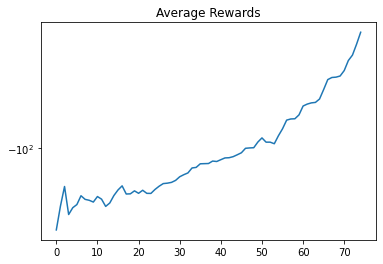

In [9]:
plt.title(f'Total Rewards')
plt.yscale('symlog')
plt.plot(totalRewards)
plt.savefig("Total Rewards",dpi=200)
plt.clf()
plt.title(f'Average Rewards')
plt.yscale('symlog')
plt.plot(averageRewards)
plt.savefig("Average Rewards",dpi=200)